<a href="https://colab.research.google.com/github/MirandaCarou/Research-Intership-Memory/blob/main/Quantum_autoencoder_1p1Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ijson
!pip install qiskit
!pip install qiskit_machine_learning
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=1efd687706fe5879db79d2cbeb69fd9da73a74e23c019120a5996cba6010eefc
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703ad

In [27]:
!pip install "pennylane-lightning[gpu]"

In [2]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import RawFeatureVector

In [39]:
datos = []
with open('ATLAS_events_v0.json', 'r', encoding='utf-8') as f:
    for item in ijson.items(f, 'item'):
        datos.append(item)
        if len(datos) >= 2:
            break

print(datos)

[{'Electrons': [{'pt': Decimal('45402.23046875'), 'eta': Decimal('0.0302922111004591'), 'phi': Decimal('-3.0952951908111572'), 'mass': Decimal('0.510998010635376'), 'charge': Decimal('-1.0')}, {'pt': Decimal('12360.97265625'), 'eta': Decimal('-2.394021511077881'), 'phi': Decimal('-0.050802238285541534'), 'mass': Decimal('0.510998010635376'), 'charge': Decimal('1.0')}], 'Muons': [], 'Jets': [{'pt': Decimal('121680.6875'), 'eta': Decimal('0.8728742003440857'), 'phi': Decimal('2.795301914215088'), 'mass': Decimal('11816.4716796875'), 'btag_prob': Decimal('0.012039952911436558')}, {'pt': Decimal('74342.7109375'), 'eta': Decimal('0.759669303894043'), 'phi': Decimal('-0.43423643708229065'), 'mass': Decimal('3198.9052734375'), 'btag_prob': Decimal('0.07718253135681152')}, {'pt': Decimal('58019.01953125'), 'eta': Decimal('-1.2548854351043701'), 'phi': Decimal('2.78841233253479'), 'mass': Decimal('2186.452880859375'), 'btag_prob': Decimal('0.012621329165995121')}, {'pt': Decimal('53487.33203125

In [40]:
def decimal_to_float(data):
    if isinstance(data, Decimal):
        return float(data)
    elif isinstance(data, dict):
        return {key: decimal_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [decimal_to_float(item) for item in data]
    else:
        return data  # Para int, str, etc.

def filtrar_jets_con_padding(datos, max_jets=10):
    eventos_con_jets = []

    for evento in datos:
        # Buscar la clave 'jets' (case insensitive)
        jets = evento.get('jets') or evento.get('Jets') or evento.get('JETS')

        if jets and len(jets) > 0:
            # Filtrar jets que tengan pt, eta y phi
            jets_filtrados = sorted(
                (
                    {
                        'pt': float(jet['pt']),
                        'eta': float(jet['eta']),
                        'phi': float(jet['phi'])
                    }
                    for jet in jets
                    if all(k in jet for k in ['pt', 'eta', 'phi'])
                ),
                key=lambda x: x['pt'],
                reverse=True
            )

            # Tomar hasta max_jets jets reales
            jets_finales = jets_filtrados[:max_jets]

            # Padding: agregar jets vacíos si hay menos de max_jets
            while len(jets_finales) < max_jets:
                jets_finales.append({'pt': 0.0, 'eta': 0.0, 'phi': 0.0})

            # Guardar el evento con los jets preparados
            eventos_con_jets.append({'Jets': jets_finales})

    return eventos_con_jets



def encontrar_maximos(datos_filtrados):
    max_pt = -float('inf')
    max_eta = -float('inf')
    max_phi = -float('inf')

    for evento in datos_filtrados:
        if 'Jets' in evento:
            for jet in evento['Jets']:
                max_pt = max(max_pt, jet['pt'])
                max_eta = max(max_eta, jet['eta'])
                max_phi = max(max_phi, jet['phi'])

    return max_pt, max_eta, max_phi

filtered_data = filtrar_jets_con_padding(datos)
filtered_data_float = [decimal_to_float(event) for event in filtered_data]
pt_jet, eta_jet, phi_jet = encontrar_maximos(filtered_data_float)
print(" Máximo pt: ", pt_jet)
print("Máximo eta: ", eta_jet)
print("Máximo phi: ", phi_jet)

 Máximo pt:  132346.625
Máximo eta:  1.3374115228652954
Máximo phi:  3.0688867568969727




> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***

Siguiendo con lo especificado en el paper....

\begin{align}
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
(p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
= \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |0\rangle \tag{3} \\
f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
\end{align}


🤔🤔 Bueno creo que voy a tomar de referencia el más grande de cada evento
 El más grande de todos

In [15]:
#Declaro la funcion 'f = f(w)' que tiene pinta que va a ser ese hiperparámtro que vamos a tener que ir mejorando

def f(w):
  return 1 + (2* np.pi / (1 + np.exp(-w)))

def phi_circuit(w, Phi, Phi_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Phi - Phi_jet)

def theta_circuit(w, Theta, Theta_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Theta - Theta_jet)


Como no tengo datos sobre que hace un jet más constituyente (*preguntar Miriam*) me baso en el btag y selecciono los 10 jets con el btag más alto.

In [7]:

num_jets = len(filtered_data_float)

print("Numbero de qubits totales: ", num_jets)


Numbero de qubits totales:  10


## **Imagen del circuito del pape**r


---

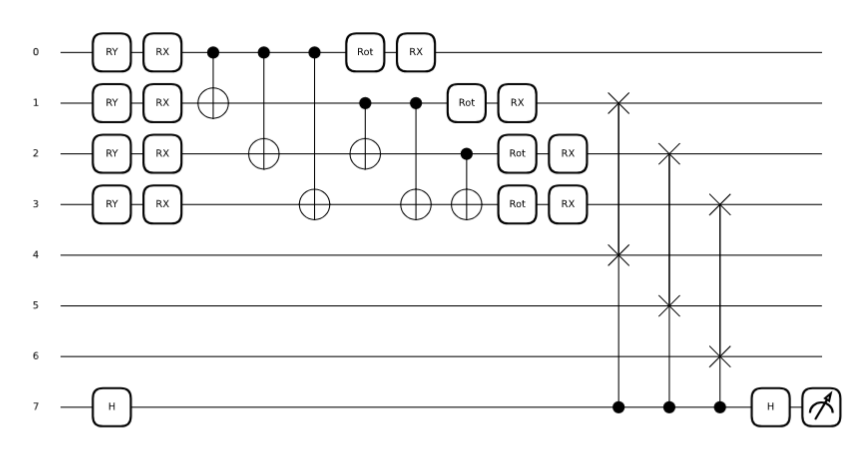

---



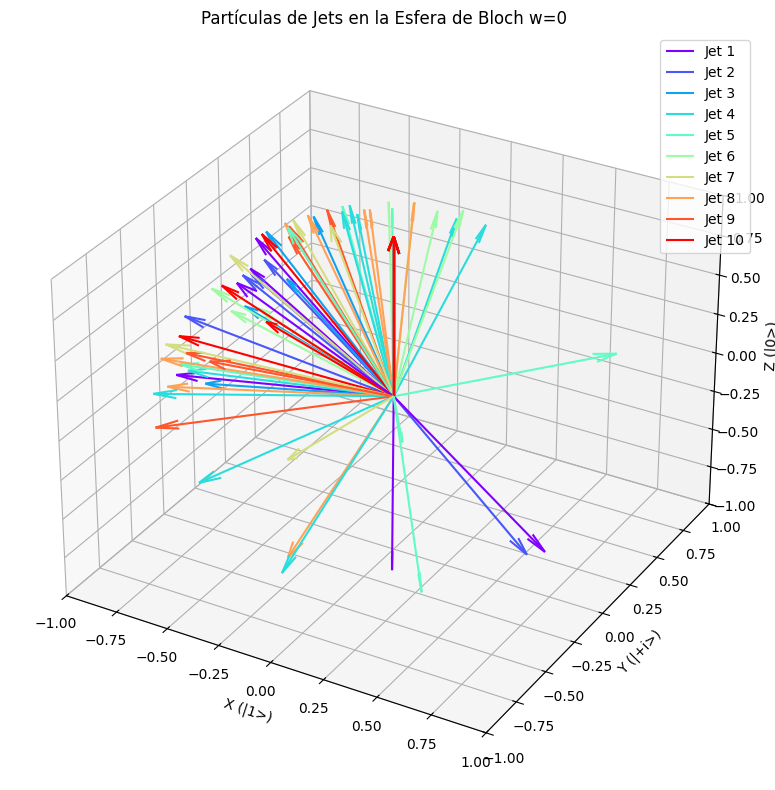

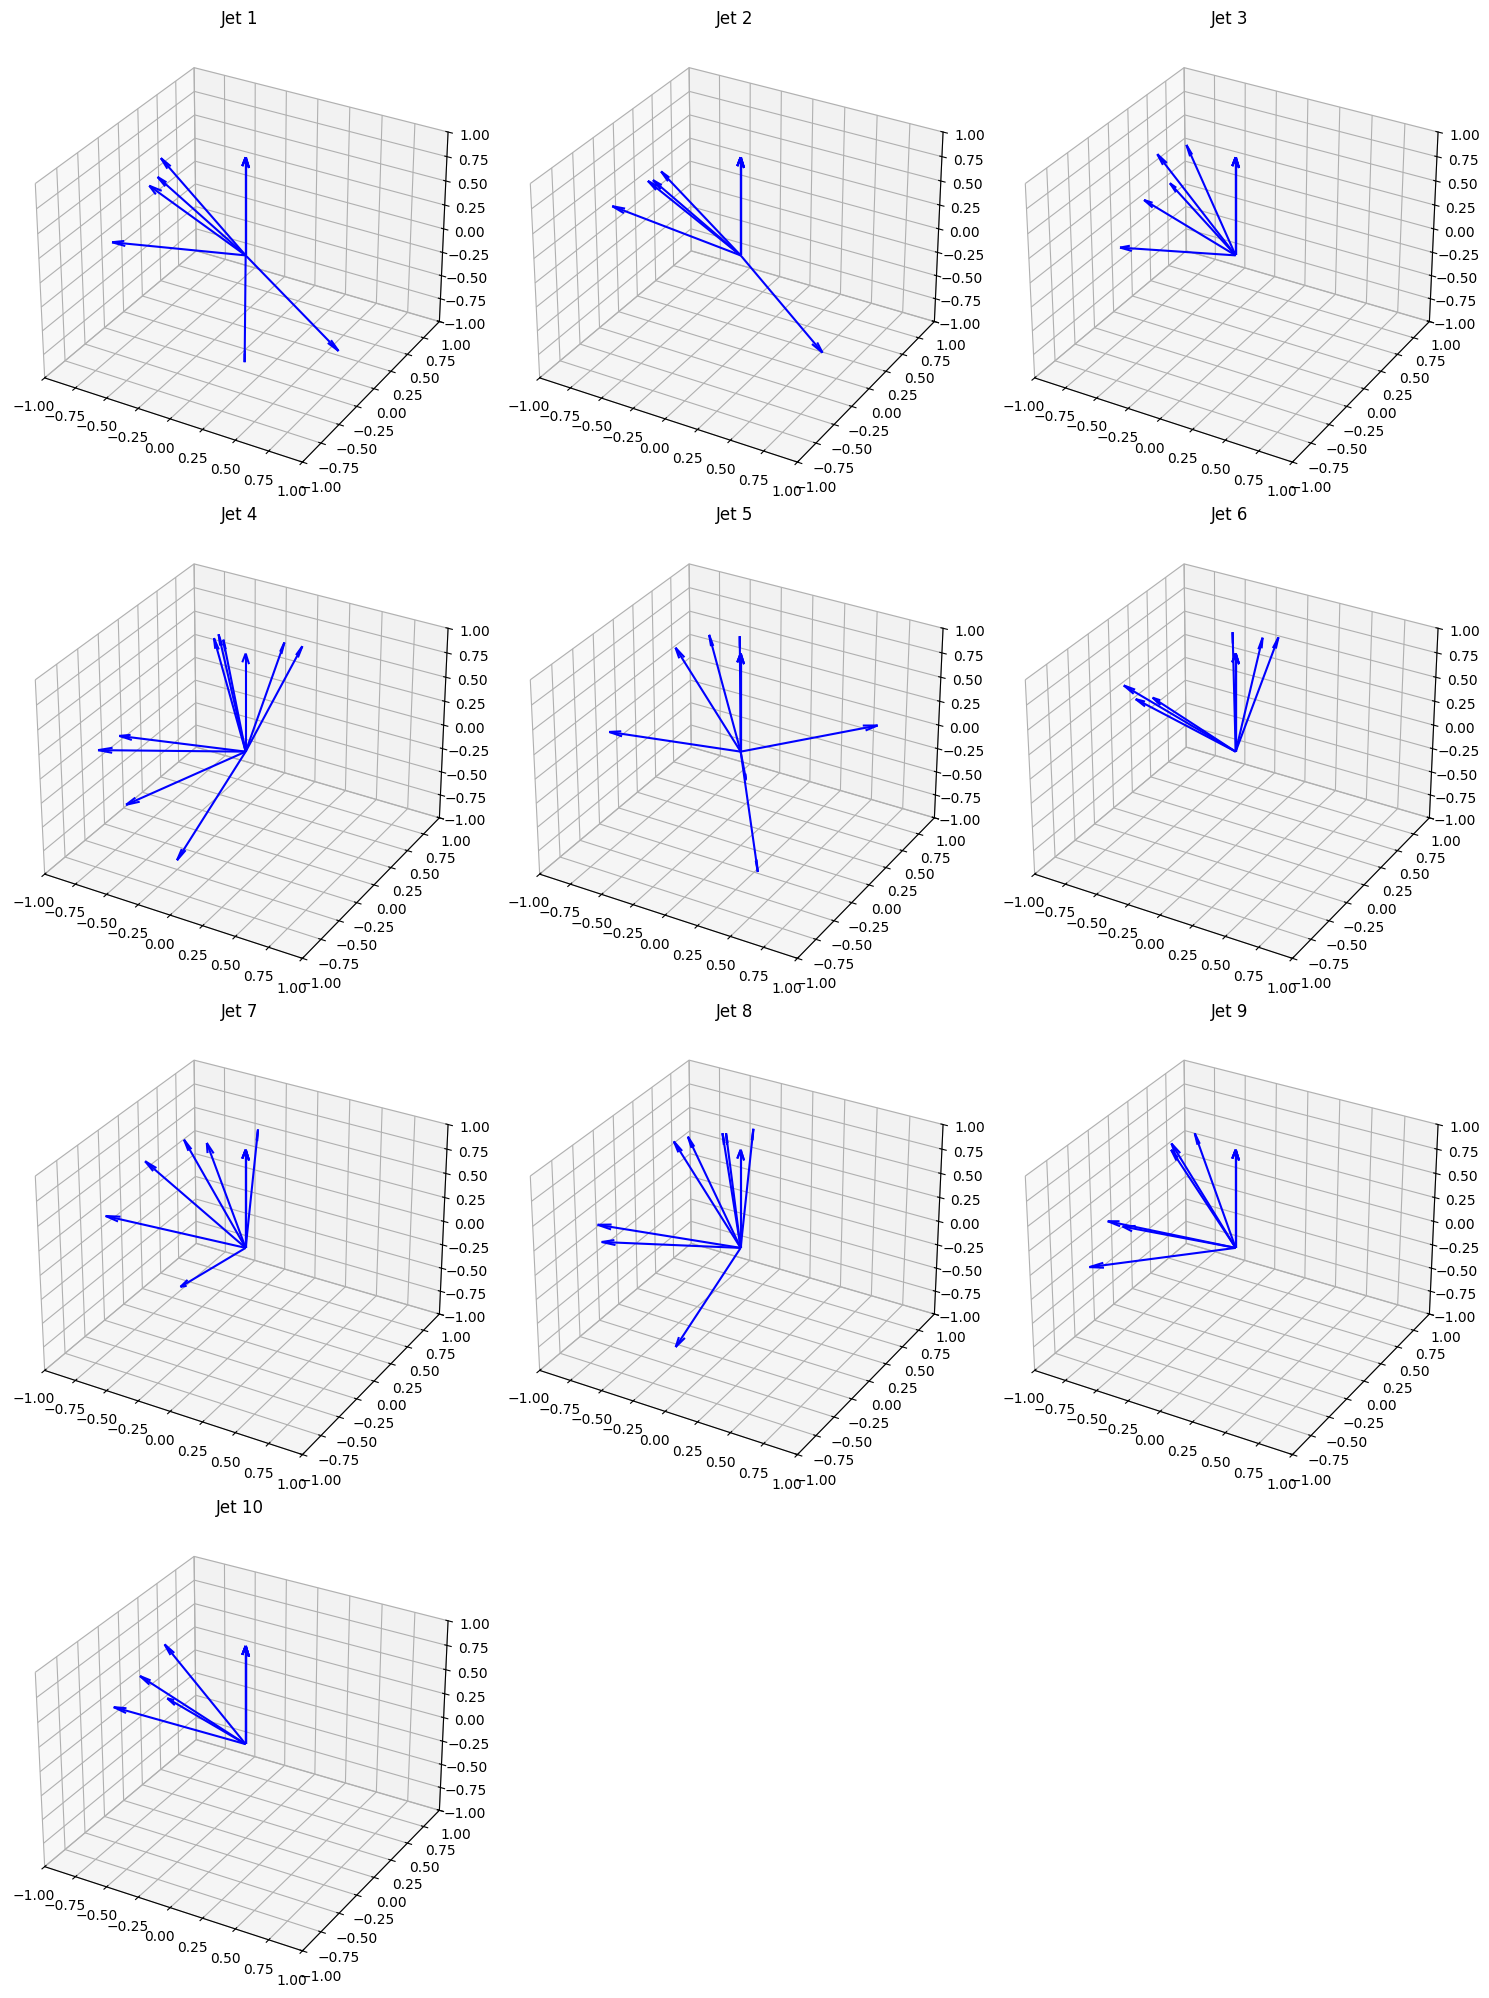

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def plot_jets_on_bloch(jets_data, num_particles=10):
    # Configurar colores distintos para cada jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets_data)))

    # Crear figura 3D para la esfera de Bloch
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        # Tomar las primeras 'num_particles' partículas del jet
        particles = jet['Jets'][:num_particles]

        for part_idx, particle in enumerate(particles):
            # Calcular theta y phi según el esquema 1P1Q
            phi = phi_circuit(0, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(0, particle['eta'], eta_jet, particle['pt'], pt_jet)

            # Crear circuito cuántico para esta partícula
            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            # Obtener el estado cuántico
            state = Statevector.from_instruction(qc)
            bloch = state.data

            # Convertir a coordenadas cartesianas
            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            # Graficar el vector con color específico para este jet
            ax.quiver(0, 0, 0, x, y, z,
                      color=colors[jet_idx],
                      arrow_length_ratio=0.1,
                      label=f'Jet {jet_idx+1}' if part_idx == 0 else "")

    # Configuración del gráfico
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X (|1>)')
    ax.set_ylabel('Y (|+i>)')
    ax.set_zlabel('Z (|0>)')
    ax.set_title('Partículas de Jets en la Esfera de Bloch w=0')

    # Mostrar leyenda
    ax.legend()
    plt.tight_layout()
    plt.show()

# Función alternativa para mostrar cada jet en una esfera separada
def plot_jets_separate_bloch(jets_data, num_particles=10):
    num_jets = len(jets_data)
    cols = 3  # Número de columnas en el grid
    rows = (num_jets + cols - 1) // cols

    fig = plt.figure(figsize=(cols*5, rows*5))

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        ax = fig.add_subplot(rows, cols, jet_idx+1, projection='3d')
        particles = jet['Jets'][:num_particles]

        for particle in particles:
            phi = phi_circuit(0, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(0, particle['eta'], eta_jet, particle['pt'], pt_jet)

            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            state = Statevector.from_instruction(qc)
            bloch = state.data

            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            ax.quiver(0, 0, 0, x, y, z,
                      color='blue',
                      arrow_length_ratio=0.1)

        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f'Jet {jet_idx+1}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_jets_on_bloch(filtered_data_float)  # Todos los jets en una esfera
plot_jets_separate_bloch(filtered_data_float)  # Jets en esferas separadas

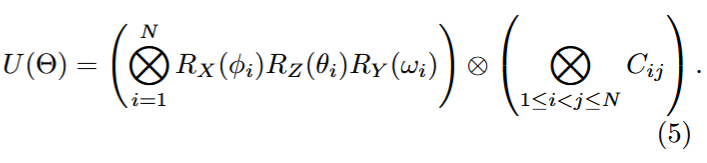

In [6]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 93.7 MB/s eta 0:00:00


In [41]:
import pennylane as qml
import torch
import numpy as np

# --- Parámetros del circuito ---
num_particles = 10
num_latent = 2
num_trash = num_particles - num_latent
wires = list(range(num_particles + num_trash + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("lightning.qubit", wires=wires, shots=1024)

# --- Codificación 1P1Q ---
def f(w): return 1 + (2 * np.pi / (1 + torch.exp(-w)))
def phi_circuit(w, phi, phi_jet, pt, pt_jet): return f(w) * pt / pt_jet * (phi - phi_jet)
def theta_circuit(w, eta, eta_jet, pt, pt_jet): return f(w) * pt / pt_jet * (eta - eta_jet)

# --- Encoder y decoder 1P1Q ---
def encode_1p1q(jets, w, pt_jet, eta_jet, phi_jet):
    for i in range(num_particles):
        theta = theta_circuit(w, jets[i]['eta'], eta_jet, jets[i]['pt'], pt_jet)
        phi = phi_circuit(w, jets[i]['phi'], phi_jet, jets[i]['pt'], pt_jet)
        qml.RY(theta, wires=i)
        qml.RX(phi, wires=i)

def decode_1p1q(jets, w, pt_jet, eta_jet, phi_jet):
    for i in reversed(range(num_particles)):
        theta = theta_circuit(w, jets[i]['eta'], eta_jet, jets[i]['pt'], pt_jet)
        phi = phi_circuit(w, jets[i]['phi'], phi_jet, jets[i]['pt'], pt_jet)
        qml.RX(-phi, wires=i)
        qml.RY(-theta, wires=i)

# --- Capa variacional (Ecuación 5) ---
def variational_layer(w):
    for i in range(num_particles):
        theta = theta_circuit(w, jets[i]['eta'], eta_jet, jets[i]['pt'], pt_jet)
        phi = phi_circuit(w, jets[i]['phi'], phi_jet, jets[i]['pt'], pt_jet)
        qml.RX(phi, wires=i)
        qml.RZ(theta, wires=i)
        qml.RY(w, wires=i)
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            qml.CNOT(wires=[i, j])

# --- Cálculo del eje del jet ---
def compute_jet_axis(jets):
    px = sum(j['pt'] * np.cos(j['phi']) for j in jets)
    py = sum(j['pt'] * np.sin(j['phi']) for j in jets)
    pz = sum(j['pt'] * np.sinh(j['eta']) for j in jets)
    pt = np.sqrt(px**2 + py**2)
    eta = np.arctanh(pz / np.sqrt(px**2 + py**2 + pz**2))
    phi = np.arctan2(py, px)
    return pt, eta, phi

# --- QAE Circuit ---
@qml.qnode(dev, interface="torch")
def qae_circuit(jets, w, pt_jet, eta_jet, phi_jet, trash_idx):
    encode_1p1q(jets, w, pt_jet, eta_jet, phi_jet)
    variational_layer(w)
    decode_1p1q(jets, w, pt_jet, eta_jet, phi_jet)

    qml.Hadamard(wires=ancilla)
    qml.CSWAP(wires=[ancilla, trash_idx, num_particles + trash_idx])
    qml.Hadamard(wires=ancilla)
    return qml.probs(wires=ancilla)


In [ ]:
def compute_fidelities(jets, w, pt_jet, eta_jet, phi_jet):
    """Calcula fidelidades vectorizadas (sin repetir qae_circuit)."""
    probs = torch.stack([
        qae_circuit(jets, w, pt_jet, eta_jet, phi_jet, i)[0]
        for i in range(num_trash)
    ])
    return 2 * probs - 1  # Fidelidades para todos los trash qubits

# --- Entrenamiento y evaluación unificados ---
w = torch.tensor(0.0, requires_grad=True)
optimizer = torch.optim.Adam([w], lr=0.01)

num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0.0
    for evento in filtered_data_float:
        jets = evento['Jets']
        pt_jet, eta_jet, phi_jet = compute_jet_axis(jets)

        # Paso forward (reutilizable)
        fidelities = compute_fidelities(jets, w, pt_jet, eta_jet, phi_jet)

        # Loss (usando las fidelidades ya calculadas)
        loss = 1 - torch.mean(fidelities)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Monitoreo (opcional, sin recalcular)
        event_fidelity = torch.mean(fidelities).item()  # <- Reusa fidelities!
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {total_loss/len(filtered_data_float):.4f}")

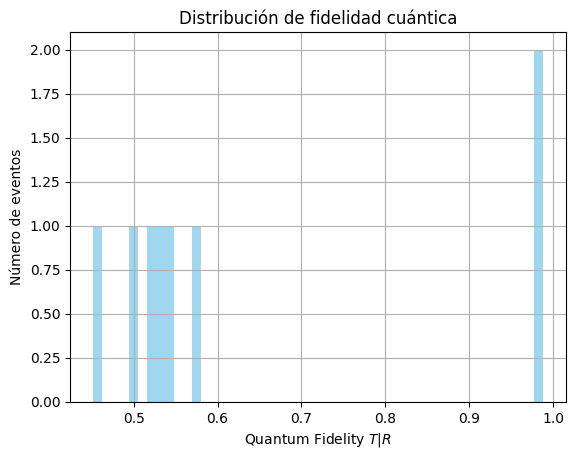

In [43]:
plt.hist(fidelities.detach().numpy(), bins=50, color='skyblue', alpha=0.8)  # ¡Corregido!
plt.xlabel("Quantum Fidelity $T|R$")
plt.ylabel("Número de eventos")
plt.title("Distribución de fidelidad cuántica")
plt.grid(True)
plt.show()


In [44]:
fidelities

tensor([0.5449, 0.5781, 0.4512, 0.5293, 0.5020, 0.5195, 0.9883, 0.9844],
       dtype=torch.float64, grad_fn=<SubBackward0>)